In [ ]:
!pip install pgmpy
!pip install pandas
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 9.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt

In [ ]:
datafile = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"

In [ ]:
data = pd.read_csv(datafile)
# Preview the dataset
data.head()

,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no.1
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [ ]:
# Add column names
column_names = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']
# Convert old column names back to data
data.append(list(data))
data.columns = column_names
data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


The missing values are denoted by "?".
We now convert into NaN.

In [ ]:
data = data.replace("?", np.nan)

# Data set infomation
print(data.isnull().sum())

class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
dtype: int64


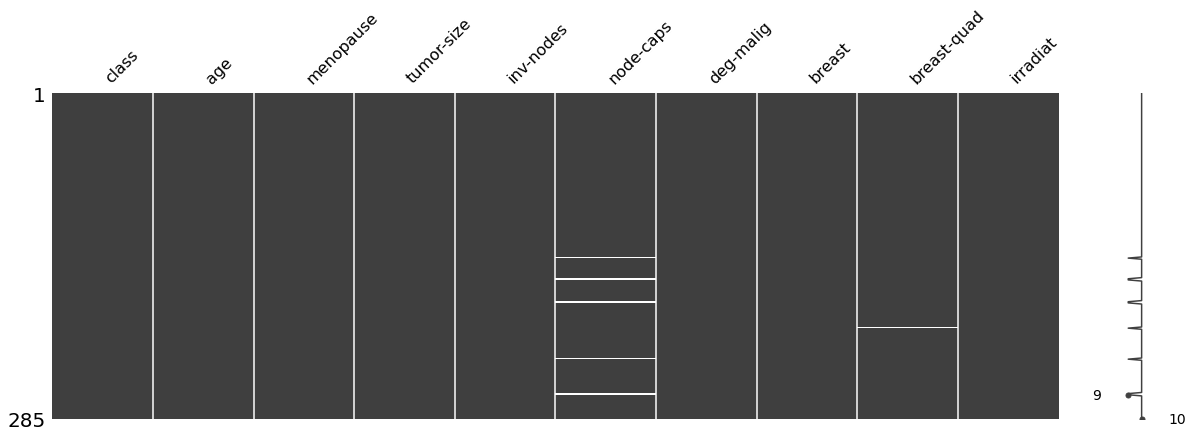

In [ ]:
# Visualisation
mno.matrix(data, figsize = (20, 6))